In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
%run -i load_pdb_file.py
# here is loading atomic structural information of an individula unit cell for different cellulose crystal.
# cii is cellulose type II which is the crystal structre of regenerated cellulose fiber.
# ca and cb are crystal structure of cellulose tpye Ialpha and Ibeta, most common for nature cellulose
cii = c2_load_pdb_file(cellulose_II_fn)
cii_c1 = c2_chain1_load_pdb_file(cellulose_II_fn)
cii_c2 = c2_chain2_load_pdb_file(cellulose_II_fn)
ciii = c3_load_pdb_file(cellulose_III_fn)
ca = ca_load_pdb_file(cellulose_Ia_fn)
cb = cb_load_pdb_file(cellulose_Ib_fn)

# calculate unit vector in real and reciprocal space enable the calculation of miller index
rvec,qvec = vec_cal(cii['a'],cii['b'],cii['c'],cii['alpha'],cii['beta'],cii['gamma'])

In [3]:
def elemental_fibril_pdb_generate(fn,obj,block_vertex=[[0,0,0]]):
    if os.path.exists(fn):
        os.remove(fn)
    a = obj['a']
    b = obj['b']
    c = obj['c']
    alpha = obj['alpha']
    beta  = obj['beta']
    gamma = obj['gamma']
    chain_vertex = [
        [3,1,0],[2,1,0],[1,1,0],[0,1,0],[-1,1,0],
        [2,0,0],[1,0,0],[0,0,0],[-1,0,0],[-2,0,0],
        [1,-1,0],[0,-1,0],[-1,-1,0],[-2,-1,0],[-3,-1,0],
        ] 
    # here < is left align, and digit is 
    header = f'COMPND UNNANMED\nCRYST1{a:>9}{b:>9}{c:>9}{alpha:>7}{beta:>7}{gamma:>7}'
    body = ''
    counts = 1
    ATOM = 'ATOM'
    LIG  = 'LIG'
    rvec,qvec = vec_cal(a,b,c,alpha,beta,gamma)
    for ___ in block_vertex:
        v1 = ___[0]*rvec['a'] + ___[1]*rvec['b'] + ___[2]*rvec['c']
        for _ in chain_vertex:
            v = _[0]*rvec['a'] + _[1]*rvec['b'] + _[2]*rvec['c']
            for __ in range(len(obj['x'])):
                atom_label = obj['atom_symbol'][__]
                x = obj['x'][__] + v[0] + v1[0]
                y = obj['y'][__] + v[1] + v1[1]
                z = obj['z'][__] + v[2] + v1[2]
                body += f'\n{ATOM:<6}{counts:>5}{atom_label:>4}{LIG:>5}{1:>4}{x:>14.3f}{y:>8.3f}{z:>8.3f}{1:>6.2f}{0:>6.2f}{atom_label:>7}'
                counts += 1
    ender = '\nEND'
    f = open(fn,'a')
    f.write(f'{header}{body}{ender}')

    
# generate pdb files for fiber models with different cross section structure, 
# which could be visualized by vmd or other software.
elemental_fibril_pdb_generate('c3_1m10_fibril.pdb',cii,[[0,0,0],[3,3,0],[-3,-3,0]])

In [4]:
def multi_fiber_xy(vertex,rvec,width,length,x,y,plane='xy'):
    xpixel = np.round(width/np.abs(np.nanmean(np.diff(x,axis=1)))).astype(int)
    if xpixel < 1:
        xpixel = 1
    ypixel = np.round(length/np.abs(np.nanmean(np.diff(y,axis=0)))).astype(int)
    if ypixel < 1:
        ypixel = 1
    m = np.zeros(x.shape).astype(bool)    
    for _ in vertex:
        v =  np.matmul(np.vstack((rvec['a'],rvec['b'],rvec['c'])),np.array(_))
        if plane == 'xy':
            c = np.argmin(np.abs(x[0,:]-v[0]))
            r = np.argmin(np.abs(y[:,0]-v[1]))
        elif plane == 'yz':
            c = np.argmin(np.abs(x[0,:]-v[1]))
            r = np.argmin(np.abs(y[:,0]-v[2]))
        elif plane == 'xz':
            c = np.argmin(np.abs(x[0,:]-v[0]))
            r = np.argmin(np.abs(y[:,0]-v[2]))
        dr = int(ypixel/2)
        dc = int(xpixel/2)
        m[(r-dr):(r+dr+1),(c-dc):(c+dc+1)] = True
    return m

In [5]:
# position presented by miller index of chain1 of cellulose crystal
vertex = [
        [3,1,0],[2,1,0],[1,1,0],[0,1,0],[-1,1,0],
        [2,0,0],[1,0,0],[0,0,0],[-1,0,0],[-2,0,0],
        [1,-1,0],[0,-1,0],[-1,-1,0],[-2,-1,0],[-3,-1,0],
        ] 

f_v1 = [[0,0,0],[3,3,0],[-3,-3,0]]
for i in f_v1:
    for j in range(len(vertex)):
        vertex.append([vertex[j][0]+i[0]*1.,vertex[j][1]+i[1]*1.,vertex[j][2]+i[2]])

<IPython.core.display.Javascript object>


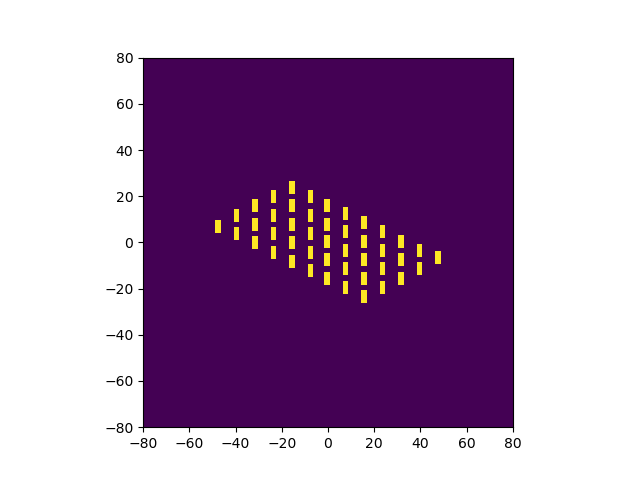

In [6]:
xmin=-80
xmax=80
ymin=-80
ymax=80
x,y = np.meshgrid(np.linspace(xmin,xmax,200),np.linspace(ymin,ymax,200))
m1 = multi_fiber_xy(vertex,rvec,2,5,x,y,plane='xy')
plt.subplots()
plt.imshow(m1.astype(float),extent=(xmin,xmax,ymin,ymax))

In [7]:
%run -i CelluloseSim_pdb.py
cii_tf1 = load_fibril_pdb_file('c3_1m10_fibril.pdb',max_rows=3780)

In [8]:
def chunk_idx(total_num,slice_num):
    total_num = int(total_num)
    slice_num = int(slice_num)
    idx  =  np.arange(0,total_num)[slice(0,total_num,slice_num)]
    idx1 =  idx
    idx2 =  np.append(idx[1:],total_num)
    return list(zip(idx1,idx2))

def single_atom_scattering_factor(_,fract_x,fract_y,fract_z,rvec_a,rvec_b,rvec_c,atom_symbol,
                                  q,rot,displacement,q_vec):
    obj_pos = np.array([fract_x[_],
                        fract_y[_],
                        fract_z[_]
                           ])
    v = rvec_a*obj_pos[0] +rvec_b*obj_pos[1]+rvec_c*obj_pos[2]
    v -= displacement
    v = np.matmul(rot,v)
    v = v.reshape(3,1)
    f = cellulose_atomic_factor(atom_symbol[_],q)
    fhkl = f
    vhkl = v
    phase = np.exp(1j*np.matmul(q_vec,vhkl))
    fhkl = np.multiply(fhkl,phase.T)
    return fhkl
    
def parallel_regenerate_cellulose_form_factor_pdb(num_cores,qx,qy,qz,pars,displacement,rota,rotb,rotc):
    '''
    for Ibeta cif sym_pos is [[1,1,1][-1,-1,1+.5]]
    for Ialpha cif sym_pos if [[1,1,1]]
    displacment is vector, here used to move mass center to origin.
    rota is angle rotate about x-axis, rotb is about yaxis, rotc is z-axis
    '''
    a = pars['a']
    b = pars['b']
    c = pars['c']
    alpha = np.radians(pars['alpha'])
    beta  = np.radians(pars['beta'])
    gamma = np.radians(pars['gamma'])
    rot = rotate_matrix(rota,rotb,rotc)
    rvec,qvec = vec_cal(a,b,c,alpha,beta,gamma,ang_unit='radians')
    #fhkl = qx.flatten()*0 + 1j*0
    q_vec = np.vstack((qx.flatten(),qy.flatten(),qz.flatten())).T
    q = np.linalg.norm(q_vec,axis=1)
    fract_x=pars['fract_x']
    fract_y= pars['fract_y']
    fract_z=pars['fract_z']
    rvec_a=rvec['a']
    rvec_b=rvec['b']
    rvec_c=rvec['c']
    atom_symbol=pars['atom_symbol']
    from multiprocessing import Pool
    from functools import partial
    partial_func = partial(single_atom_scattering_factor,fract_x=fract_x,
    fract_y=fract_y,
    fract_z=fract_z,
    rvec_a=rvec_a,
    rvec_b=rvec_b,
    rvec_c=rvec_c,
    atom_symbol=atom_symbol,q=q,rot=rot,displacement=displacement,q_vec=q_vec)
    idx_list = chunk_idx(len(pars['atom_symbol']),1000)
    for _ in range(len(idx_list)):       
        p = Pool(num_cores)
        with p:
            res = p.map(partial_func,range(idx_list[_][0],
                                           idx_list[_][1]))
        if _ == 0:
            fres = np.array(res)
            fhkl = np.sum(fres,axis=0)
        else:
            fres = np.array(res)
            fhkl += np.sum(fres,axis=0)
        p.close()
    return fhkl.reshape(qx.shape)

In [9]:
import time
t = time.time()
qx,qy = np.meshgrid(np.linspace(-3,3,1501),np.linspace(-3,3,1501))
fb = parallel_regenerate_cellulose_form_factor_pdb(120,qx,qy,qx*0,cii,np.array([0.,0.,0.]),0.,0.,0.)
fb_d1 = parallel_regenerate_cellulose_form_factor_pdb(120,qx,qy,qx*0,cii_tf1,np.array([0.,0.,0.]),0.,0.,0.)
print(time.time()-t)

761.2569553852081


<IPython.core.display.Javascript object>


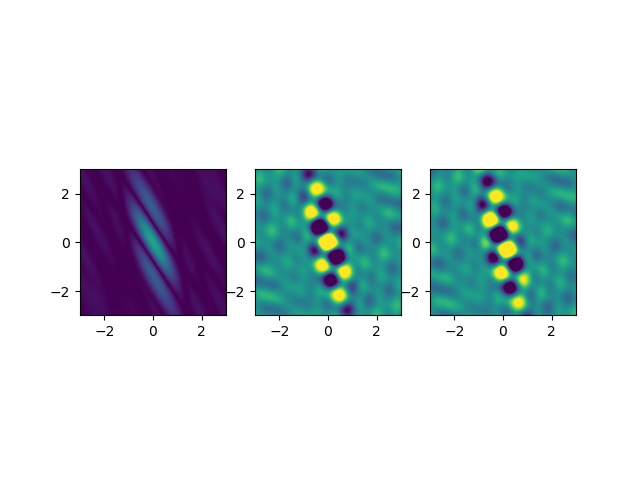

<IPython.core.display.Javascript object>


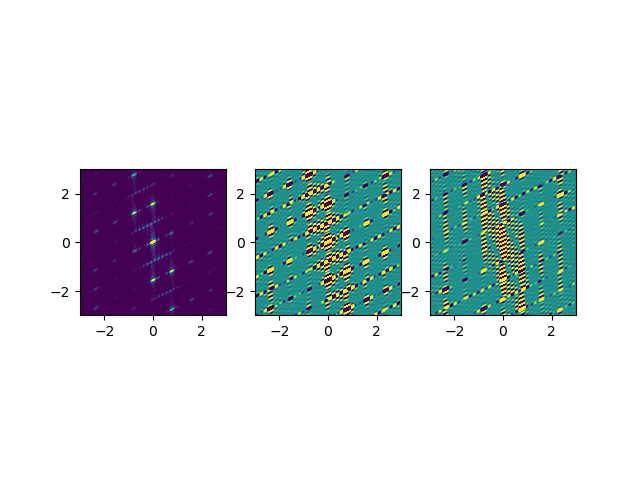

In [10]:
plt.subplots()
plt.subplot(131)
plt.imshow(np.abs(fb),vmin=10,vmax=580,extent=(-3,3,-3,3))
plt.subplot(132)
plt.imshow(fb.real,vmin=-100,vmax=100,extent=(-3,3,-3,3))
plt.subplot(133)
plt.imshow(fb.imag,vmin=-100,vmax=100,extent=(-3,3,-3,3))

plt.subplots()
plt.subplot(131)
plt.imshow(np.abs(fb_d1),vmin=100,vmax=5800,extent=(-3,3,-3,3))
plt.subplot(132)
plt.imshow(fb_d1.real,vmin=-100,vmax=100,extent=(-3,3,-3,3))
plt.subplot(133)
plt.imshow(fb_d1.imag,vmin=-100,vmax=100,extent=(-3,3,-3,3))

<IPython.core.display.Javascript object>


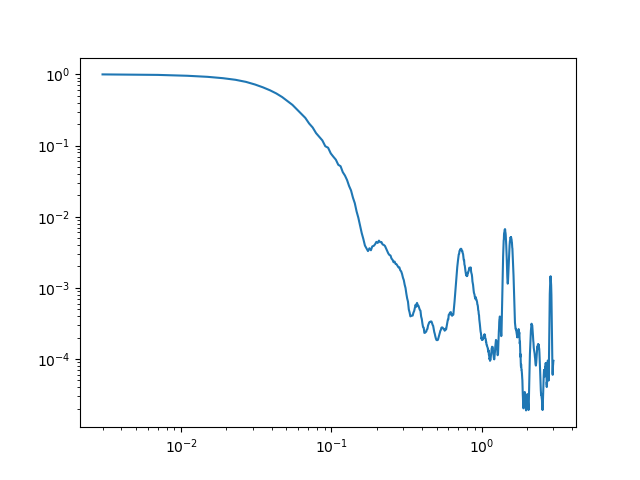

In [11]:
qr = np.sqrt(qx**2+qy**2)
qstart = 0.001
qend   = 3
bins = 751
# calculate 1D intensity by histogram binning of 2D pattern
q = (np.linspace(qstart,qend,bins)[1:] + np.linspace(qstart,qend,bins)[:-1])/2
qr1,dqr1 = np.histogram(qr,bins=np.linspace(qstart,qend,bins),weights=np.ones(qr.shape))

is1 = np.abs(fb_d1*np.conj(fb_d1))#np.abs(fb_d1)#p11+f11*p12+f 11*p21+f11*p22)
In11,dI1 = np.histogram(qr,bins=np.linspace(qstart,qend,bins),weights=is1)
# here is calculating circluar averaged intensity, which is cylindrical averaging
In11 /= qr1


plt.subplots()
plt.loglog(
         q,In11/np.nanmax(In11),
        )